# Stabilize Landmark Points

In this script, I stabilize the facial keypoints for the Tron video.
To predict the keypoints, I use code from here: https://github.com/1adrianb/face-alignment

My best results came from improving the quality of the keypoints for each frame. To do this, I augmented the input by flipping and rotating the original image.

I rotated the image from -48 deg to 48 deg in 12 deg steps giving 9 images.
Doing the same on the flipped image gives 18 total input images per frame.

Finally, I average all of the results giving the improved keypoint predictions for that frame.

In [30]:
import sys
sys.path.insert(0, '../face-alignment')
import face_alignment
from skimage import io
import cv2
import numpy as np
import visvis as vv
from tqdm import tqdm_notebook as tqdm
import math

In [31]:
fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._3D, 
                                  enable_cuda=False, 
                                  flip_input=False)

In [3]:
 def load_img(file_name):
    img = cv2.imread(file_name)
    if "tron" in file_name:
        img = img[115:640, 763:1287, :]
    return img

In [4]:
def screenshot(preds, img, output_file_name):
    vv.clf()
    
    im = img
    t = vv.imshow(im)
    t.interpolate = True

    x, y, z = np.array(zip(*(preds[0])))
    
    z = z + 100
    
    def plot(x, y, z, mc):
        vv.plot(x, y, z, mc=mc, ls="", ms=".", mw=3)
    
    a = 17
    plot(x[:a], y[:a], z[:a], mc=(1, 0, 0))
    
    b = a + 10
    plot(x[a:b], y[a:b], z[a:b], mc=(0, 1, 0))
    
    a, b = b, b + 9
    plot(x[a:b], y[a:b], z[a:b], mc=(0, 0, 1))
    
    a, b = b, b + 6
    plot(x[a:b], y[a:b], z[a:b], mc=(1, 1, 0))
    
    a, b = b, b + 6
    plot(x[a:b], y[a:b], z[a:b], mc=(0, 1, 1))
    
    a, b = b, b + 12
    plot(x[a:b], y[a:b], z[a:b], mc=(.5, 1, .2))
    
    plot(x[b:], y[b:], z[b:], mc=(1, 0, 1))

    a = vv.gca()
    a.camera.fov = 0 # orthographic
    a.camera.azimuth = 0
    a.camera.elevation = 90
    a.camera.roll = 0

    if output_file_name is None:
        vv.use().Run()
    else:
        vv.screenshot(output_file_name, vv.gcf(), sf=2, bg='w')

https://stackoverflow.com/questions/6802577/python-rotation-of-3d-vector

In [5]:
def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis/math.sqrt(np.dot(axis, axis))
    a = math.cos(theta/2.0)
    b, c, d = -axis*math.sin(theta/2.0)
    aa, bb, cc, dd = a*a, b*b, c*c, d*d
    bc, ad, ac, ab, bd, cd = b*c, a*d, a*c, a*b, b*d, c*d
    return np.array([[aa+bb-cc-dd, 2*(bc+ad), 2*(bd-ac)],
                     [2*(bc-ad), aa+cc-bb-dd, 2*(cd+ab)],
                     [2*(bd+ac), 2*(cd-ab), aa+dd-bb-cc]])

In [6]:
def rotate(img, d):
    rows,cols, _ = img.shape
    M = cv2.getRotationMatrix2D((cols/2,rows/2),d,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    return dst

def augments(img):
    rows,cols, _ = img.shape
    for d in range(-48, 49, 12):
        theta = d * math.pi / 180.0
        rot_img = rotate(img, d)
        r = rotation_matrix((0, 0, -1), -theta)
        
        def reverse(pred):
            offset = (cols/2.0, rows/2.0, 0)
            pred[0] = np.dot(pred[0] - offset, r.T) + offset
            return pred
        
        yield rot_img, reverse

#### Get all the predictions for a frame and then average them together

In [7]:
def get_keypoints(file_name, flip=False):
    img = load_img(file_name)
    if flip:
        img = cv2.flip(img, 1)
    img_pred = np.zeros((1, 68, 3))
    n = 0
    for rot_img, reverse in augments(img):
        pred = fa.get_landmarks(rot_img)
        if pred is not None:
            pred = reverse(pred)
            img_pred[0] = img_pred[0] + pred[0]
            n += 1
    img_pred[0] = img_pred[0] / float(n)
    if flip:
        img_pred[0,:,0] = img.shape[0] - img_pred[0,:,0]
    return img_pred

In [ ]:
dir = "/Users/paul/Downloads/tron_frames"
preds = [get_keypoints("{}/frame{:04d}.jpg".format(dir, i)) 
         for i in tqdm(range(1, 101))]

In [9]:
preds_flip = [get_keypoints("{}/frame{:04d}.jpg".format(dir, i), 
                            flip=True) 
              for i in tqdm(range(1, 101))]

HBox(children=(IntProgress(value=0, max=88), HTML(value=u'')))

In [10]:
def flip_keypoints(pred):
    tmp_pred = np.copy(pred)
    a = 17
    tmp_pred[:a] = pred[:a][::-1]
    
    b = a + 10
    tmp_pred[a:b] = pred[a:b][::-1]
    
    b += 4
    
    a, b = b, b + 5
    tmp_pred[a:b] = pred[a:b][::-1]
    
    a = b
    
    tmp_pred[a:a+4], 
    tmp_pred[a+6:a+10] = pred[a+6:a+10][::-1], pred[a:a+4][::-1]
    
    tmp_pred[a+4:a+6],
    tmp_pred[a+10:a+12] = pred[a+10:a+12][::-1], pred[a+4:a+6][::-1]
    
    a, b = a + 12, b + 19
    tmp_pred[a:b] = pred[a:b][::-1]
    
    a, b = b, b + 5
    tmp_pred[a:b] = pred[a:b][::-1]
    
    a, b = b, b + 5
    tmp_pred[a:b] = pred[a:b][::-1]
    
    a, b = b, b + 3
    tmp_pred[a:b] = pred[a:b][::-1]
                          
    return tmp_pred

In [20]:
for i in range(88):
    preds_flip[i,0] = flip_keypoints(preds_flip[i,0])

ValueError: cannot copy sequence with size 2 to array axis with dimension 4

#### Average the original and flipped predictions together

In [157]:
preds_smooth = (preds[:,0,:,:] + preds_flip[:,0,:,:]) / 2.0

In [23]:
preds_smooth = np.array(preds)[:,0,:,:]

In [26]:
preds_smooth[:,0,:,2] = preds_smooth[:,0,:,2] + 100

IndexError: too many indices for array

In [27]:
preds_smooth[:,:,2] = preds_smooth[:,:,2] + 100

In [28]:
np.save('keypoints_preds_smooth', np.array(preds_smooth))

In [160]:
for i in range(1, 101):
    img = load_img("{}/frame{:04d}.jpg".format(dir, i))
    pred = preds_smooth[i - 1]
    screenshot([pred], img, "tron_keyframes_smooth/frame{:04d}.jpg".format(i))

In [32]:
for i in range(1, 89):
    img = load_img("{}/frame{:04d}.jpg".format(dir, i))
    pred = preds_smooth[i - 1]
    screenshot([pred], img, "leia_keyframes_smooth/frame{:04d}.jpg".format(i))

/Users/paul/miniconda2/lib/python2.7/site-packages/imageio/core/util.py:78: UserWarning: Lossy conversion from float32 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


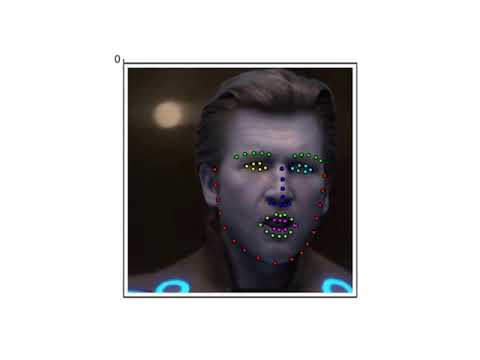

In [1]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('q5jAZuFcqlQ')

Here I do some preperation for the face swap script, I use the same method as above to get keypoints for the face I will swap into the tron video.

In [174]:
img = load_img("/Users/paul/Downloads/tron_frames/frame0001.jpg")
img.shape

(525, 524, 3)

In [ ]:
pred = get_keypoints("joey.jpg")
pred_flip = get_keypoints("joey.jpg", flip=True)
pred_flip[0] = flip_keypoints(pred_flip[0])
pred_smooth = (pred[0] + pred_flip[0]) / 2.0
np.save('joey_keypoints.npy', pred_smooth)

In [175]:
img = load_img("joey.jpg")
img.shape

(639, 639, 3)